# TM10007 Assignment template -- ECG data

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [270]:
import os
import zipfile
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn
import math
import statistics
import math
import numpy as np
from scipy.stats import shapiro 
from scipy.stats import lognorm

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA

cwd = os.getcwd() # This fn will return the Current Working Directory

zip_path = os.path.join(cwd, 'ecg', 'ecg_data.zip')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(cwd, 'ecg'))

data_path = os.path.join(cwd, 'ecg', 'ecg_data.csv')
data = pd.read_csv(data_path, index_col=0)

Exploring data
- How many people have a normal ECG?
- How many people have an abnormal ECG?
- Is there any missing data?
- Are there outliers? -> nog bedenken wat we hier mee willen!


In [271]:
# split labels from data
x = data.loc[:, data.columns != 'label']  #alles behalve label
y = data['label']  # labels

# normal / abnormal ECGs
total_abnormal_ECG = np.count_nonzero(y)  # current dataset has 146 nonzeros
total_normal_ECG = y.size -np.count_nonzero(y)  # current dataset has 681 zeros
percentage_abnormal = total_abnormal_ECG / (total_abnormal_ECG + total_normal_ECG)*100  # 17.65 %

# Missing data
x = x.replace(0, np.nan)  # make all zeros to NaN
nan_count = x.isna().sum().sum()  # count missing data -> 10500 in our dataset

# Outliers



Missing data
- Removing features if there is lot of data missing (replace all for a value)
- Removing samples (in this case patients) if there is a lot of data missing
- Imputation for generating data to fill us missing values -> median

Exploring
- Is the data normally distributed?

In [272]:
# Determine the amount of features
n_features = x.shape[1]
print(n_features, 'Number of features')

# Determine the amount of patients
n_patients = x.shape[0]
print(n_patients, 'Number of patients')

# Delete missing data when > --% of feature of sample is missing
x = x.dropna(axis='columns', how='all') # deletes a feature if all values of a column (so feature) are empty
x = x.dropna(axis='rows', how='all') # deletes a patient if all values of a row (so sample) are empty

# Missing data to median per feature
for column in x.columns:
    x[column].fillna(x[column].median(), inplace=True)

# Normally distributed
stat = []
p = []
for col in x.columns:
    if x[col].dtype == 'float64' or x[col].dtype == 'int64':
        s, pv = shapiro(x[col])
        stat.append(s)
        p.append(pv)
    else:
        stat.append(None)
        p.append(None)

# create a new dataframe to store the results
results = pd.DataFrame({'Column': x.columns, 'W': stat, 'p-value': p}) 
mean_p_value = results['p-value'].mean()  # p-value is really small. If p-value is bigger than 0.05, then data is normally distributed. SO its not
median_p_value = results['p-value'].median()  # p-value is really small. If p-value is bigger than 0.05, then data is normally distributed. SO its not

# Outliers: Tukey's fence 
k=1.5
fences=pd.DataFrame()
for col in x.columns:
    q1, q3 = np.percentile(x[col], [25, 75])
    iqr = q3 - q1
    lower_fence = q1 - k*iqr
    upper_fence = q3 + k*iqr
    fences[col]=[lower_fence, upper_fence]
print(fences)

9000 Number of features
827 Number of patients


C:\Users\irisv\AppData\Local\Temp\ipykernel_14280\491687389.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fences[col]=[lower_fence, upper_fence]
C:\Users\irisv\AppData\Local\Temp\ipykernel_14280\491687389.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fences[col]=[lower_fence, upper_fence]
C:\Users\irisv\AppData\Local\Temp\ipykernel_14280\491687389.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

          0_0         0_1        0_2        0_3        0_4         0_5  \
0 -551.936329  -54.217384 -34.243313 -23.447067 -26.858542  -52.084347   
1  930.248701  107.962490  77.068042  60.083444  70.095744  121.916094   

          0_6         0_7        0_8        0_9  ...    11_740    11_741  \
0  -72.197603  -43.788241 -24.257702 -19.203845  ... -0.158056 -0.152630   
1  164.850756  104.300629  62.294661  51.232231  ...  0.493230  0.473293   

     11_742    11_743    11_744    11_745    11_746    11_747    11_748  \
0 -0.182649 -0.164168 -0.170385 -0.150881 -0.171495 -0.183951 -0.179681   
1  0.533231  0.494073  0.490670  0.475182  0.512232  0.515514  0.506062   

     11_749  
0 -0.166584  
1  0.489180  

[2 rows x 9000 columns]


Splitting data into training and test data
- Subset training and test based on ratios
- Stratification
- Cross-validation?




In [273]:
# Split data
X_train, X_test_DO_NOT_FIT, y_train, y_test_DO_NOT_FIT = model_selection.train_test_split(x, y, test_size=0.25, stratify=y)
y_train_ab = y_train==1  # waarom maken we hier bools van? ipv 1 en 0 hebben we nu true en false
# X_test_DO_NOT_FIT and y_test_DO_NOT_FIT SHOULD NOT BE USED FOR FITTING

# Scale the data to be normal
scaler = preprocessing.RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled_DO_NOT_FIT = scaler.transform(X_test_DO_NOT_FIT)

# Cross-validation
# cv_20fold = model_selection.StratifiedKFold(n_splits=10) --> uit college 1.2_generalization.ipyb

# Loop over the folds
#for validation_index, test_index in cv_20fold.split(X2, y2):
    # Split the data properly
#    X_validation = X2[validation_index]
#    y_validation = y2[validation_index]
    
#    X_test = X2[test_index]
#    y_test = y2[test_index]


Feature selection: lets try -> LET OP: VOOR NU EVEN ALLE DATA, DIT NOG AANPASSEN
- Greedy
- Univariate

In [274]:
# Greedy method


# Univariate method
x_univar = SelectKBest(f_classif, k=10).fit_transform(x, y)  # welke k wil je? 
print(x_univar.shape)

(827, 10)


Univariate


In [275]:
# univariate feature selection
# k = 1000 # number of top features to select
# selector = SelectKBest(f_classif, k=k)
# X_new = selector.fit_transform(X, y)
# selected_features = np.array(range(X.shape[1]))[selector.get_support()]

# X_new now contains only the k top features
# selected_features contains the indices of the selected features in the original X array

PCA
- How many principal components? (n=2/3) --> to make plots visual
- Scree plot to determine amount of features to use?


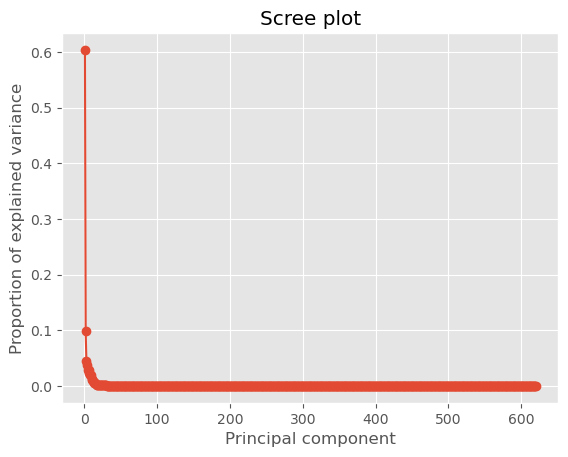

In [276]:
# Reduce the number of features with PCA.
pca = PCA()
pca.fit(X_train)
explained_variance_ratio = pca.explained_variance_ratio_

# plt.bar(np.arange(1, len(explained_variance_ratio)+1), explained_variance_ratio*100)
# plt.xlabel('Principal Component Index')
# plt.ylabel('Explained Variance Percentage')
# plt.show()

# # Scree plot?
# p = PCA(n_components=0.99)
# p = p.fit(X_train)
# X_train = p.transform(X_train)
# print(X_train.shape)
# p.explained_variance_
# plt.style.use("ggplot") 
# plt.plot(p.explained_variance_, marker='o')
# plt.xlabel("Eigenvalue number")
# plt.ylabel("Eigenvalue size")
# # plt.title("Scree Plot")

# assume X is your data matrix containing 827 patients and 9000 features
# pca = PCA(n_components=X_train.shape[1])
# pca.fit(X_train)

# generate scree plot
plt.plot(np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, 'o-')
plt.xlabel('Principal component')
plt.ylabel('Proportion of explained variance')
plt.title('Scree plot')
plt.show()




